In [1]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageOps, ImageFilter
import requests
from io import BytesIO

In [2]:
dataDir = '../..'
dataType = 'val2017'
annDir = '{}/annotations'.format(dataDir)
annZipFile = '{}/annotations_train{}.zip'.format(dataDir, dataType)
annFile = '{}/instances_{}.json'.format(annDir, dataType)
annURL = 'http://images.cocodataset.org/annotations/annotations_train{}.zip'.format(dataType)
print (annDir)
print (annFile)
print (annZipFile)
print (annURL)

../../annotations
../../annotations/instances_val2017.json
../../annotations_trainval2017.zip
http://images.cocodataset.org/annotations/annotations_trainval2017.zip


In [3]:
if not os.path.exists(annDir):
    os.makedirs(annDir)
if not os.path.exists(annFile):
    if not os.path.exists(annZipFile):
        print ("Downloading zipped annotations to " + annZipFile + " ...")
        with urllib.request.urlopen(annURL) as resp, open(annZipFile, 'wb') as out:
            shutil.copyfileobj(resp, out)
        print ("... done downloading.")
    print ("Unzipping " + annZipFile)
    with zipfile.ZipFile(annZipFile,"r") as zip_ref:
        zip_ref.extractall(dataDir)
    print ("... done unzipping")
print ("Will use annotations in " + annFile)

Will use annotations in ../../annotations/instances_val2017.json


In [4]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.36s)
creating index...
index created!


In [5]:
cats = coco.loadCats(coco.getCatIds())
nms = [cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(', '.join(nms)))

COCO categories: 
person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, traffic light, fire hydrant, stop sign, parking meter, bench, bird, cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe, backpack, umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, sports ball, kite, baseball bat, baseball glove, skateboard, surfboard, tennis racket, bottle, wine glass, cup, fork, knife, spoon, bowl, banana, apple, sandwich, orange, broccoli, carrot, hot dog, pizza, donut, cake, chair, couch, potted plant, bed, dining table, toilet, tv, laptop, mouse, remote, keyboard, cell phone, microwave, oven, toaster, sink, refrigerator, book, clock, vase, scissors, teddy bear, hair drier, toothbrush



In [1109]:
catIds = coco.getCatIds(catNms=['cat'])  # For example, get cats
imgIds = coco.getImgIds(catIds=catIds)
images = coco.loadImgs(imgIds)

In [1300]:
img = images[np.random.randint(0, len(images))]

In [1304]:
img

{'license': 3,
 'file_name': '000000209747.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000209747.jpg',
 'height': 350,
 'width': 500,
 'date_captured': '2013-11-15 06:31:33',
 'flickr_url': 'http://farm1.staticflickr.com/90/248270582_f41115367b_z.jpg',
 'id': 209747}

In [1301]:
response = requests.get(img['coco_url'])
image = Image.open(BytesIO(response.content)).convert('RGBA')

In [1302]:
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)

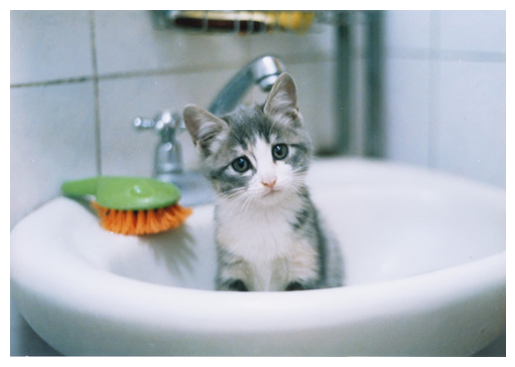

In [1303]:
I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

# Object Crop

In [992]:
mask_data = np.zeros((img['height'], img['width']), dtype=np.uint8)
for ann in anns:
    mask_data = np.maximum(coco.annToMask(ann) * 255, mask_data)

In [335]:
mask = Image.fromarray(mask_data).convert('L')

In [336]:
rgba_mask = Image.merge('RGBA', (mask, mask, mask, mask))

In [337]:
background = Image.new('RGB', (img['width'], img['height']), (255, 255, 255))

In [338]:
overlay_image = Image.composite(image, background, rgba_mask)

In [339]:
overlay_image_rgb = overlay_image.convert('RGB')

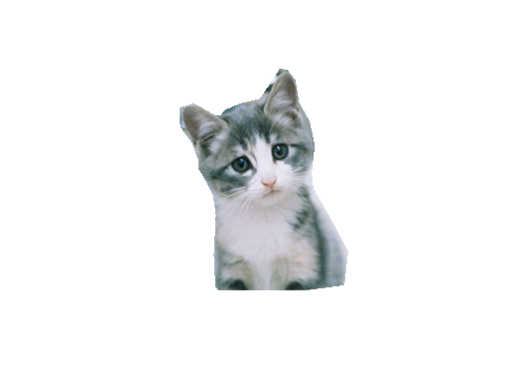

In [340]:
plt.imshow(overlay_image_rgb)
plt.axis('off')
plt.show()

# Object Highlight

In [341]:
highlight_color = (0, 255, 0, 255)  # Green color with full opacity
highlight_image = Image.new('RGBA', (img['width'], img['height']), highlight_color)

In [342]:
highlighted_object = Image.composite(highlight_image, image, mask)

In [343]:
background_color = (0, 0, 255, 255)  # Blue solid color
solid_background = Image.new('RGBA', (img['width'], img['height']), background_color)

In [344]:
final_image = Image.composite(highlighted_object, solid_background, mask)

In [345]:
final_image_rgb = final_image.convert('RGB')

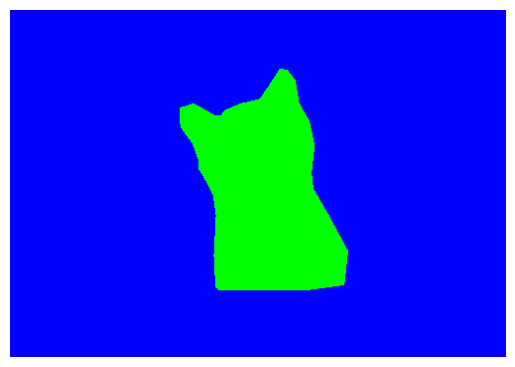

In [346]:
plt.imshow(final_image_rgb)
plt.axis('off')
plt.show()

# Background Blur

In [347]:
blurred_background = image.filter(ImageFilter.GaussianBlur(10))

In [348]:
object_image = Image.composite(image, blurred_background, mask)

In [349]:
object_image_rgb = object_image.convert('RGB')

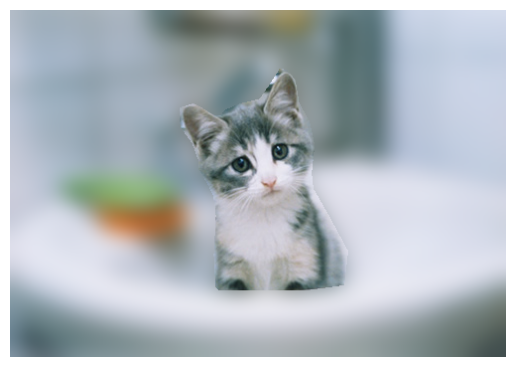

In [350]:
plt.imshow(object_image_rgb)
plt.axis('off')
plt.show()

# Cropped Image

In [351]:
bbox = anns[0]['bbox']
bbox = [int(round(b)) for b in bbox]
x, y, width, height = bbox
cropped_image = image.crop((x, y, x+width, y+height))

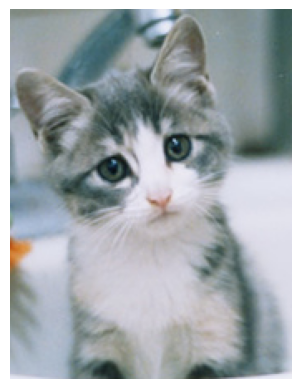

In [352]:
plt.imshow(cropped_image)
plt.axis('off')
plt.show()

# Rotated Image

In [353]:
angle = 45
rotated_image = image.rotate(angle, expand=True)

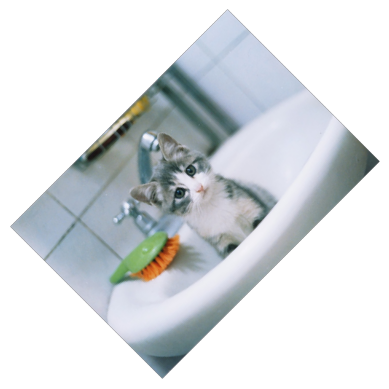

In [354]:
plt.imshow(rotated_image)
plt.axis('off')
plt.show()